Vision Transformer Paper Link:- https://arxiv.org/pdf/2010.11929v2.pdf

How Transformer Works Fully Explained:- https://jalammar.github.io/illustrated-transformer/

In [1]:
from helper_functions import download_data, set_seeds, plot_loss_curves
from going_moduler import data_setup, engine
from torchinfo import summary
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
print(torch.__version__)
print(torchvision.__version__)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.empty_cache()

1.12.1+cu102
0.13.1+cu102


In [2]:
# Setup device agnostic code.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# 1. Get Data

In [3]:
# 2. Setup directory path
train_dir = os.path.join("Datasets", "pizza_steak_sushi", "train")
test_dir = os.path.join("Datasets", "pizza_steak_sushi", "test")

train_dir, test_dir

('Datasets/pizza_steak_sushi/train', 'Datasets/pizza_steak_sushi/test')

# 2. Create Datasets and DataLoaders

In [4]:
from torchvision import transforms

# Create Image Data
IMG_SIZE = 224  # Comes from Table 3 from ViT Paper.

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
    ])

print(f"Manual Created Transforms: {manual_transforms}")

Manual Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [5]:
# Create a batch size of 16 (the paper uses 4096, but due to hardware resources, we gonna use 16)
BATCH_SIZE = 4

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
    num_workers = os.cpu_count()
    )

len(train_dataloader), len(test_dataloader), class_names

(57, 19, ['pizza', 'steak', 'sushi'])

torch.Size([3, 224, 224]) tensor(1)


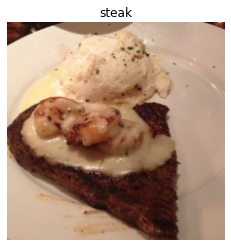

In [6]:
# Visualize a single Image
# Get a Batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot the image
plt.imshow(image.permute(1, 2, 0)) # (CC, H, W) -> (H, W, CC)
plt.title(class_names[label])
plt.axis(False)
plt.show()

# 3. Replicating a ViT: Overview

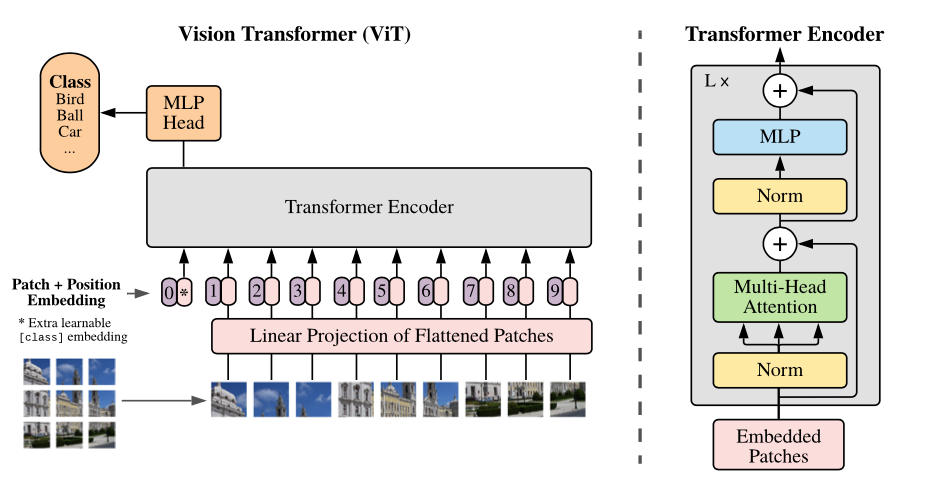

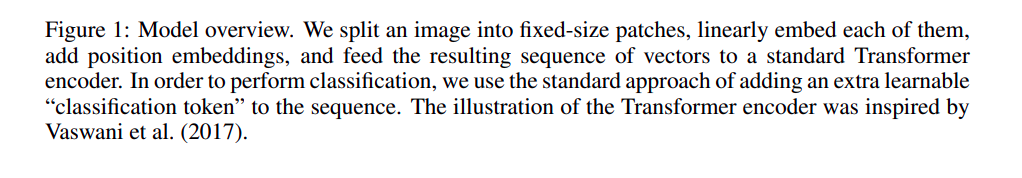

### Four Equations
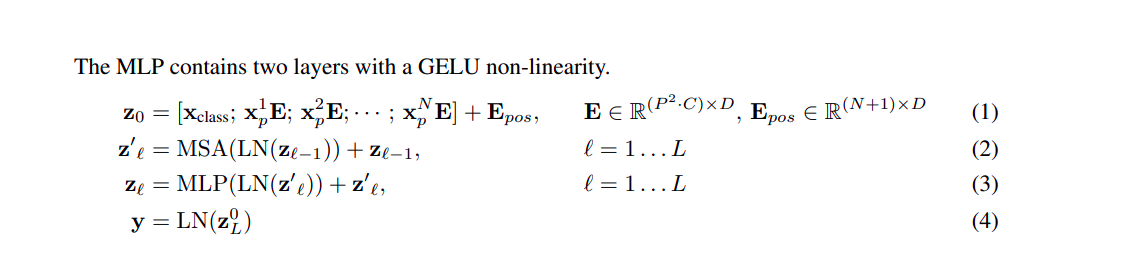

### Table 1:
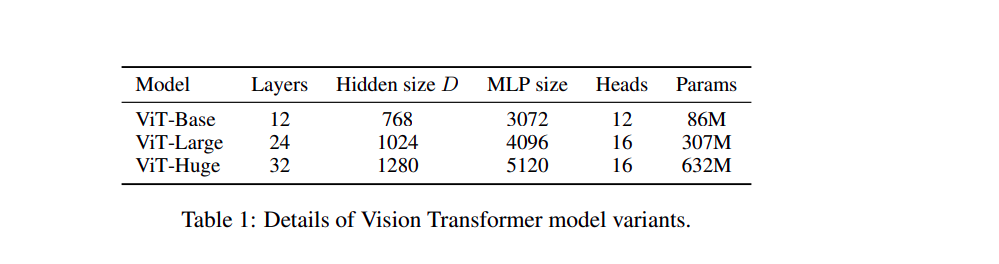

## We gonna replicate ViT-Base

# 4.1 Calculating the Input and Output Shape of the Embedding Layer by Hand

### Equation 1: Split data into patches and creating the class, position and patch embeddings

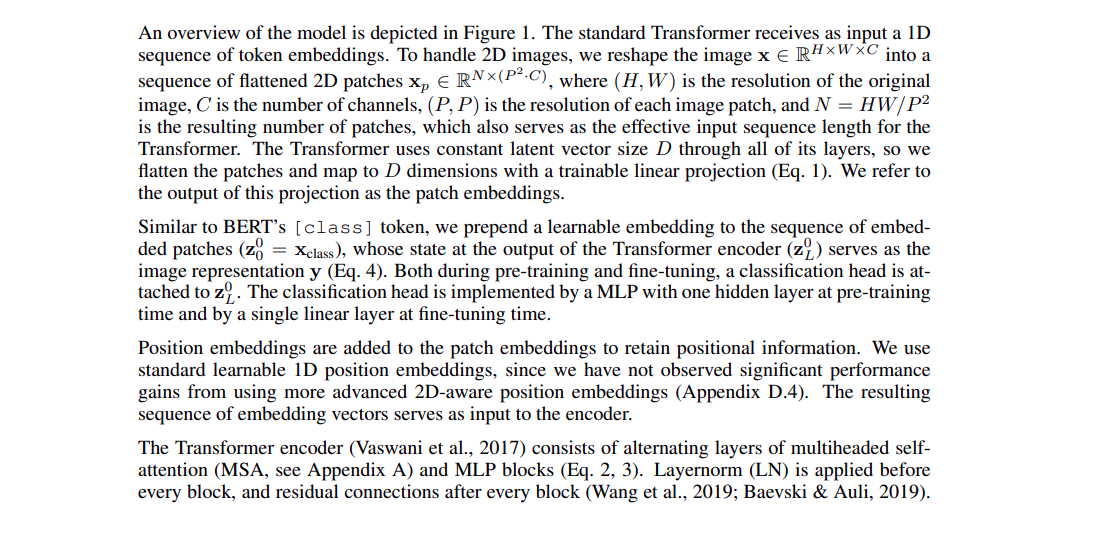

- Input Image Shape:- H x W x C (height x width x color channel)
- Output Shape:- N x (P**2 . C)
- H = height
- W = weight
- C = color channel
- P = patch_size
- N = Number of patches = (height * width) / p**2
- D = constant latent size = embedding dimensions 

In [7]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size ** 2)
print(number_of_patches)

196


In [8]:
# Input Shape
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape (Output Shape:- N x (P**2 . C))
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)  

print(f"Input Shape (Single 2D image): {embedding_layer_input_shape}")
print(f"Output Shape (Single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)") 

Input Shape (Single 2D image): (224, 224, 3)
Output Shape (Single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


# 4.2.1 Turning a Single Image into Patches (Part 1: Patching the Top Row)

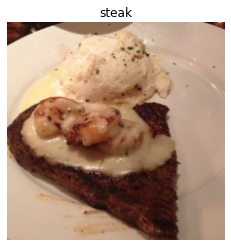

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [10]:
image.shape

torch.Size([3, 224, 224])

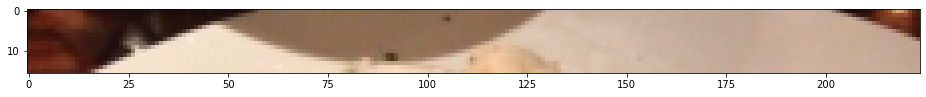

In [11]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # -> For matplotlib

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])  #  (H = 0:16, W = full, CC = all 3)
plt.show()

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


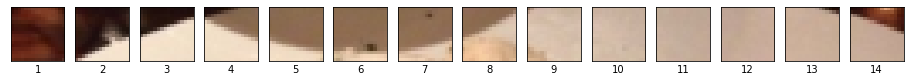

In [12]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size,  # One column for each patch
                        sharex = True,
                        sharey = True,
                        figsize = (patch_size, patch_size))


# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, :])
    axs[i].set_xlabel(i+1)  # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# 4.2.2 Turning a Single Image into Patches (Part 2: Patching the Entire Image)

Number of patches per row: 14.0    
NUmber of patches per column: 14.0    
Total patches: 196.0    
Patch size: 16 pixels x 16 pixels


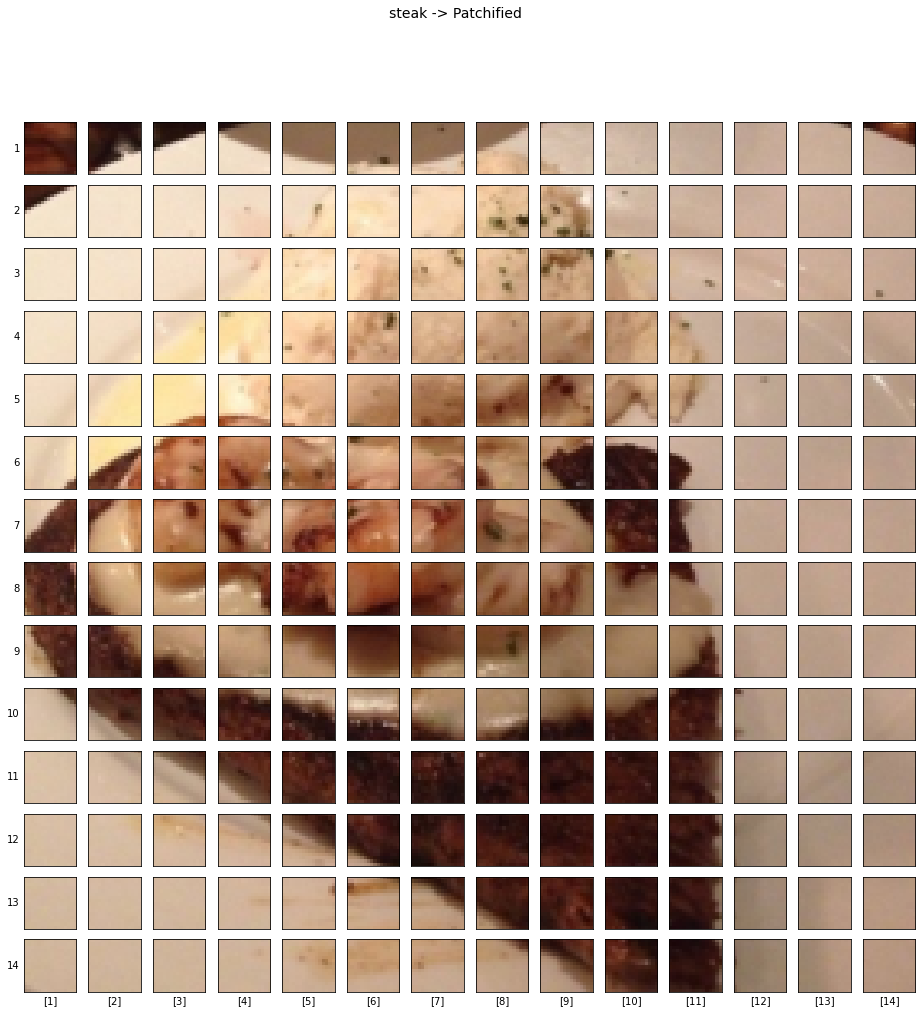

In [13]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}\
    \nNUmber of patches per column: {num_patches}\
    \nTotal patches: {num_patches * num_patches}\
    \nPatch size: {patch_size} pixels x {patch_size} pixels")



# Create a series of subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,  # One column for each patch
                        sharex = True,
                        sharey = True,
                        figsize = (patch_size, patch_size))


# Iterate through number of patches in the top row
for i, patch_height in enumerate(range(0, img_size, patch_size)):  # Iterate through height.
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image on the different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height + patch_size,  # Iterate through height
                                       patch_width:patch_width + patch_size,     # Iterate through width
                                       :])    # get all color channels
        # Setup label information for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                             rotation = "horizontal",
                             horizontalalignment = "right",
                             verticalalignment = "center")  
        axs[i, j].set_xlabel([j+1])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

# 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` 
and setting the kernel size and stride to `patch_size`.

In [14]:
# Create conv2d layer to turn image into patches of learnable feature maps (embaddings).
import torch.nn as nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from ViT paper.
conv2d = nn.Conv2d(in_channels = 3,      # for color images
                   out_channels = 768,   # D size from Table 1
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0
                  )

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

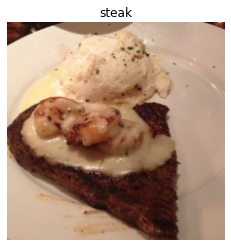

In [15]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [16]:
# Pass the image through convolutional layer.

image_out_of_conv = conv2d(image.unsqueeze(0))  # add batch dimension -> (BS, CC, H, W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


### Now we have passed a single image to our `conv2d` layer, it's shape is:
`torch.Size([1, 768, 14, 14])  # [BS, embedding_dims, feature_map_height, feature_map_width]`

Showing random convolutional feature maps from indexes: [168, 602, 482, 620, 680]


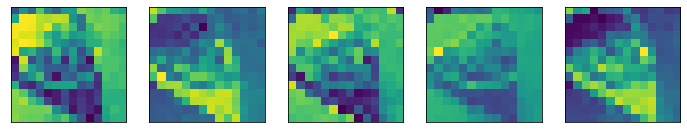

In [17]:
# Plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]   # index on the output tensor of the conv2d layer.
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())  # remove batch dimension, and switch to numpy for matplotlib/ removes from grad tracking.
    axs[i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

# 4.4 Flattening the patch embedding with `torch.nn.Flatten()`
Right now we have a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [18]:
print(image_out_of_conv.shape)    # [BS, embedding_dims, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


- Want: (BS, number_of_patches, embedding_dims) -> In this format only.
- We got embedding_dims already that is 768, just need to flatten last 2 index to get no_of_patches.

In [19]:
flatten_layer = nn.Flatten(start_dim = 2, 
                           end_dim = 3)

flatten_layer(image_out_of_conv)

tensor([[[ 0.0245, -0.0256,  0.0320,  ...,  0.0578,  0.0410,  0.0402],
         [ 0.0474,  0.0131,  0.0037,  ...,  0.1309,  0.1526,  0.1498],
         [-0.0129, -0.1502,  0.2621,  ...,  0.0296,  0.0576,  0.0877],
         ...,
         [-0.1331, -0.1566, -0.0061,  ..., -0.0750, -0.0770, -0.0296],
         [-0.2053, -0.2606, -0.1101,  ..., -0.1477, -0.1741, -0.1615],
         [-0.0361, -0.0421,  0.0257,  ..., -0.0813, -0.0969, -0.0795]]],
       grad_fn=<ReshapeAliasBackward0>)

In [20]:
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
image_out_of_conv_flattened.shape    # We got [BS, embedding_dims, no_of_patches]

torch.Size([1, 768, 196])

In [21]:
# Rearrange output of flattened layer in required format [BS, number_of_patches, embedding_dims]
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(image_out_of_conv_flattened_permuted.shape)

torch.Size([1, 196, 768])


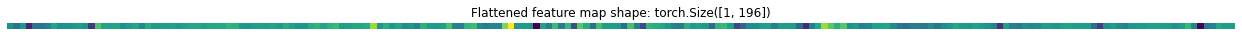

In [22]:
# Get a single flattened_feature_map 
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]  # [BS, no_of_patches, embedding_dim]

# Plot the flattened feature map visually
plt.figure(figsize = (22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)
plt.show()

# 4.5 Training the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
- 1) Create a class called `PatchEmbedding` that inherits from `nn.Module`.
- 2) Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
- 3) Create a layer to turn an image into embedded patches using `nn.Conv2d()`.
- 4) Create a layer to flatten the feature maps of the output of the layer in 3.
- 5) Define a `forward()` that defines the forward computation.
- 6) Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [23]:
# 1. Create a class called PatchEmbedding.
class PatchEmbedding(nn.Module):
    # 2. Initialize the layer with appropriate hyperparameters.
    def __init__(self, 
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768   # From Table 1 for Vit-Base
                 ):
        super().__init__()
        
        self.patch_size = patch_size

        # 3. Create a layer to turn an image into embedded patches.
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0
                                 )

        # 4. Create a layer to flatten the feature maps of the output of the Conv2d layer in 3.
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)


    # 5. Define a forward method for the forward computation steps.
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape.
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make the returned sequence embedding dimensions are in the right order (BS, number_of_patches, embedding_dim).
        return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)


# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))     # add an extra batch dimension.
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


# 4.6 Creating the class token embedding

#### Want to: prepend a learnable class token to the start of the patch embedding.

In [25]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [26]:
# Get the batch size and embedding dimension.
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [27]:
# Creating class token embedding as a learning parameter that shares the same size as the embedding dimension (D).
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [28]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [29]:
# Add the class token embedding to the front of the patch embedding.
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1)  # number_of_patches_dimension

print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, class_token + num_of_patches, embedding_dim)")

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.1880,  0.0040, -0.0303,  ...,  0.1429, -0.1395,  0.1229],
         [-0.3752,  0.0779, -0.3381,  ...,  0.4781, -0.1838, -0.0794],
         ...,
         [-0.5741,  0.1340, -0.1459,  ...,  0.3921, -0.2498,  0.1796],
         [-0.6655,  0.1538, -0.1351,  ...,  0.4499, -0.3047,  0.1808],
         [-0.6639,  0.1278, -0.1550,  ...,  0.4585, -0.3175,  0.2366]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + num_of_patches, embedding_dim)


# 4.7 Creating the position embedding.

### Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings. 

In [30]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
          [-0.1880,  0.0040, -0.0303,  ...,  0.1429, -0.1395,  0.1229],
          [-0.3752,  0.0779, -0.3381,  ...,  0.4781, -0.1838, -0.0794],
          ...,
          [-0.5741,  0.1340, -0.1459,  ...,  0.3921, -0.2498,  0.1796],
          [-0.6655,  0.1538, -0.1351,  ...,  0.4499, -0.3047,  0.1808],
          [-0.6639,  0.1278, -0.1550,  ...,  0.4585, -0.3175,  0.2366]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [31]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding.
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), 
                                  requires_grad = True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [32]:
# Add the position embedding to the patch and class token embedding as shown in equation 1 in the paper.
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[ 1.5436,  0.5300, -0.2133,  ...,  0.5429,  1.4486,  1.1217],
          [ 0.8120,  1.0040,  0.9697,  ...,  1.1429,  0.8605,  1.1229],
          [ 0.6248,  1.0779,  0.6619,  ...,  1.4781,  0.8162,  0.9206],
          ...,
          [ 0.4259,  1.1340,  0.8541,  ...,  1.3921,  0.7502,  1.1796],
          [ 0.3345,  1.1538,  0.8649,  ...,  1.4499,  0.6953,  1.1808],
          [ 0.3361,  1.1278,  0.8450,  ...,  1.4585,  0.6825,  1.2366]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

- As you can see, all the values has been added by 1.

# 4.8 Putting it all together: from image to patch_and_position_embedding

In [33]:
# Set Seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of original image tensor and get the image dimensions.
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch Embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)   # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim = 1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and Position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch Embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and Position embedding shape: torch.Size([1, 197, 768])


# 5. Equation 2: MultiHead Self-Attention (MSA Block)


- Multihead self-attention = which part of a sequence should pay the most attention to itself.

- LayerNorm = Layer Normalization (LN) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.



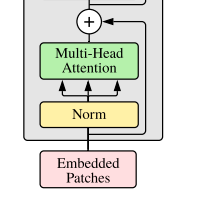

- `NOTE:- Skip Connection we will include later on.`

In [34]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA" block for short).
    """
    def __init__(self,
                 embedding_dim: int = 768,  # Hidden size D (embedding dimension) from Table 1 for Vit-Base.
                 num_heads: int = 12,       # Heads from Table 1 for Vit-Base
                 attn_dropout: int = 0 
                 ):
        
        super().__init__()
        
        # Create a Norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first = True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights = False)
         
        return attn_output                                                                                

In [35]:
# Create an instance of MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768,
                                                             num_heads = 12,
                                                             attn_dropout = 0)

# Pass the patch and position image embedding sequence through MSA block.
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Patch and Position embedding as an Input for MSA block:\n {patch_and_position_embedding}\n")
print(f"Output after MSA block:\n {patched_image_through_msa_block}")

Patch and Position embedding as an Input for MSA block:
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8120, 1.0040, 0.9697,  ..., 1.1429, 0.8605, 1.1229],
         [0.6248, 1.0779, 0.6619,  ..., 1.4781, 0.8162, 0.9206],
         ...,
         [0.4259, 1.1340, 0.8541,  ..., 1.3921, 0.7502, 1.1796],
         [0.3345, 1.1538, 0.8649,  ..., 1.4499, 0.6953, 1.1808],
         [0.3361, 1.1278, 0.8450,  ..., 1.4585, 0.6825, 1.2366]]],
       grad_fn=<AddBackward0>)

Output after MSA block:
 tensor([[[-0.2438, -0.2626,  0.0759,  ..., -0.4375,  0.9207, -0.4957],
         [-0.2319, -0.2649,  0.0793,  ..., -0.4319,  0.9315, -0.5127],
         [-0.2426, -0.2560,  0.0862,  ..., -0.4291,  0.9291, -0.5046],
         ...,
         [-0.2378, -0.2579,  0.0816,  ..., -0.4339,  0.9356, -0.5100],
         [-0.2376, -0.2584,  0.0811,  ..., -0.4342,  0.9355, -0.5103],
         [-0.2374, -0.2578,  0.0814,  ..., -0.4346,  0.9359, -0.5106]]],
       grad_fn=<TransposeBackward0>)


# 6. Equation 3: Multilayer Perceptron (MLP block)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1).
* MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
* MLP number of hidden units = MLP Size in Table 1.
* Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing.

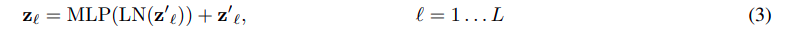

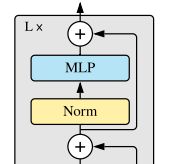

In [36]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 dropout: int = 0.1
                ):
        
        super().__init__()
        
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        
        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim),
            nn.Dropout(p = dropout)
            )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x

In [37]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input coming from MSA Block to MLP block:\n {patch_and_position_embedding}\n")
print(f"Output after MLP block:\n {patched_image_through_msa_block}")

Input coming from MSA Block to MLP block:
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8120, 1.0040, 0.9697,  ..., 1.1429, 0.8605, 1.1229],
         [0.6248, 1.0779, 0.6619,  ..., 1.4781, 0.8162, 0.9206],
         ...,
         [0.4259, 1.1340, 0.8541,  ..., 1.3921, 0.7502, 1.1796],
         [0.3345, 1.1538, 0.8649,  ..., 1.4499, 0.6953, 1.1808],
         [0.3361, 1.1278, 0.8450,  ..., 1.4585, 0.6825, 1.2366]]],
       grad_fn=<AddBackward0>)

Output after MLP block:
 tensor([[[-0.2438, -0.2626,  0.0759,  ..., -0.4375,  0.9207, -0.4957],
         [-0.2319, -0.2649,  0.0793,  ..., -0.4319,  0.9315, -0.5127],
         [-0.2426, -0.2560,  0.0862,  ..., -0.4291,  0.9291, -0.5046],
         ...,
         [-0.2378, -0.2579,  0.0816,  ..., -0.4339,  0.9356, -0.5100],
         [-0.2376, -0.2584,  0.0811,  ..., -0.4342,  0.9355, -0.5103],
         [-0.2374, -0.2578,  0.0814,  ..., -0.4346,  0.9359, -0.5106]]],
       grad_fn=<TransposeBackward0>)


# 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).
And there are residule connections between each block.

- Encoder = turn a sequence into learnable representation.
- Decoder = go from learn representation back to some sort of sequence.
- Residual connections = add a layer(s) input to its subsequent output, this enables the creation of deeper networks (pervents weights from getting too small).

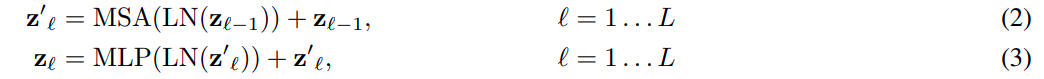

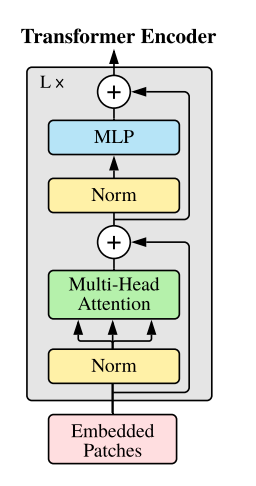

### 7.1 Create a custom Transformer Encoder Block

In [38]:
class TranformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,  # Hidden size D from Table 1, 768 for ViT-Base.
                 num_heads: int = 12,       # from Table 1
                 mlp_size: int = 3072,      # from Table 1
                 mlp_dropout: int = 0.1,    # from Table 3
                 attn_dropout: int = 0
                ):
        
        super().__init__()
        
        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                     num_heads = num_heads,
                                                     attn_dropout = attn_dropout)
        
        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                            mlp_size = mlp_size,
                            dropout = mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x  # adding residual/skip connection for equation 2.
        x = self.mlp_block(x) + x  # adding residual/skip connection for equation 3.
        
        return x

In [39]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TranformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),   # Output of Embedded patches -> (BS, no_of_patches, embedding_dimension).
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TranformerEncoderBlock (TranformerEncoderBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with in-built Pytorch Layers

So far we've created a transformer encoder by hand.

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers.

In [40]:
# Create the same as above with torch.nn.TransformerEncoderLayer().
torch_transormer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                            nhead = 12,
                                                            dim_feedforward = 3072,
                                                            dropout = 0.1,
                                                            activation = "gelu",
                                                            batch_first = True,
                                                            norm_first = True)

torch_transormer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [41]:
# Get a summary using torchinfo.summary
summary(model = torch_transormer_encoder_layer,
        input_size = (1, 197, 768),   # Output of Embedded patches -> (BS, no_of_patches, embedding_dimension).
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# 8. Putting it all together to create ViT

In [42]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
                 img_size: int = 224,   # Table 3 from the ViT paper.
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,  # Table 1 for "Layers" for ViT-Base.
                 embedding_dim: int = 768,       # Hidden Size D from Table 1 for Vit-Base.
                 mlp_size: int = 3072,     # Table 1
                 num_heads: int = 12,      # Table 1
                 attn_dropout: int = 0,
                 mlp_dropout: int = 0.1,
                 embedding_dropout: int = 0.1,  # Dropout for patch and position embeddings
                 num_classes: int = 1000        # no of classes in our dataset
                ):
        
        super().__init__()
        
        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"
        
        # Calculate the number of patches (height * width / patch**2)
        self.num_patches = (img_size * img_size) // patch_size**2
        
        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                             requires_grad = True)
        
        # Create learnable position embedding
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim))
        
        # Create embeddinng dropout value
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)
        
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                              patch_size = patch_size,
                                              embedding_dim = embedding_dim)
        
        # Create the Transformer Encoder Block
        self.transformer_encoder = nn.Sequential(*[TranformerEncoderBlock(embedding_dim = embedding_dim,
                                                                          num_heads = num_heads,
                                                                          mlp_size = mlp_size,
                                                                          mlp_dropout = mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim,
                      out_features = num_classes)
            )
        
        
        
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]
        
        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) #  "-1" means to infer the dimensions.
        
        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)
        
        # Concat class tokens embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim = 1)  # (BS, no_of_patches, embedding_dim)
        
        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x
        
        # Apply dropout to patch embedding ("directly after adding positional - to patch embeddings")
        x = self.embedding_dropout(x)
        
        # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
        x = self.transformer_encoder(x)
        
        # Put 0th index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])
        
        return x

In [43]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we are working with that is 3.
vit = ViT(num_classes = 3)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [44]:
# Getting a visual summary of our ViT model
from torchinfo import summary

summary(model = ViT(num_classes = 3),
        input_size = (1, 3, 224, 224),    # (BS, color_channel, height , width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TranformerEncoderBlock (0)                            [1, 197, 768]        [1, 197, 768] 

# 9. Setting up training code for our custom ViT
We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data.

### 9.1 Creating an Optimizer
The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.999 (defaults) and a weight decay of 0.1                   

In [45]:
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr = 1e-3,   # or 0.001, from paper
                             betas = (0.9, 0.999),  # by deafults
                             weight_decay = 0.1     # from paper
                            )

### 9.2 Creating a Loss function

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()

## 9.3 Training our ViT Model

In [47]:
torch.cuda.is_available()

True

In [48]:
device

'cuda'

In [49]:
from going_moduler import engine

set_seeds()

results = engine.train(model = vit.to(device),
                       train_dataloader = train_dataloader, 
                       test_dataloader = test_dataloader,
                       epochs = 5, 
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.9553 | Train acc: 0.3772 | Test Loss: 2.1845 | Test Acc: 0.3289
Epoch: 1 | Train Loss: 1.3119 | Train acc: 0.2763 | Test Loss: 1.3438 | Test Acc: 0.3289
Epoch: 2 | Train Loss: 1.1980 | Train acc: 0.3465 | Test Loss: 1.2113 | Test Acc: 0.3289
Epoch: 3 | Train Loss: 1.1914 | Train acc: 0.2719 | Test Loss: 1.1457 | Test Acc: 0.3289
Epoch: 4 | Train Loss: 1.1420 | Train acc: 0.2895 | Test Loss: 1.1202 | Test Acc: 0.3289


### 9.4 What our training setup is missing?

How is our training setup different to the ViT paper?

We have replicated model architecture correctly.

But what was different between our training procedure (to get such poor results) and the ViT paper training procedure to get such great results?

The main thngs our training implementation is missing:

Prevent underfitting:

* Data - our setup uses far less data (225 vs millions in ViT paper)

Prevent overfitting:
- Learning rate warmup - start with a low learning rate and increase to a base LR.
- Learning rate decay - as your model gets closer to convergence, start to lower the learning rate.
- Gradient clipping - prevent gradients from getting too big.

## 9.5 Plotting Loss Curves for our model

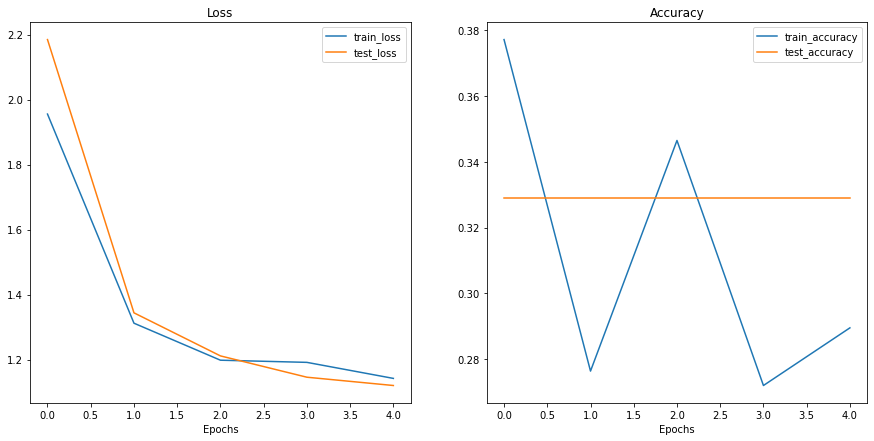

In [50]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# 10.1 Using a pretrained ViT from `torchvision.models`

In [51]:
# The following requires torch v0.12+ and torchvision 0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu102
0.13.1+cu102


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [53]:
# Get pre-trained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # "DEFAULT" = best available;

# Setup a ViT instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Update the classifier head
set_seeds()

pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names)).to(device)

In [54]:
summary(model = pretrained_vit,
        input_size = (1, 3, 224, 224),    # (BS, color_channel, height , width)
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 10.2 Preparing data for the pretrained ViT model

When using a pre-trained model, you want to make sure your data is formatted in the same way that the model was trained on.

In [55]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [56]:
# Setup dataloaders
from going_moduler import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                     test_dir = test_dir,
                                                                                                     transform = vit_transforms,
                                                                                                     batch_size = 8)  

## 10.3 Train Pre-Trained ViT Model

In [57]:
from going_moduler import engine

# Create Optimizer and Loss function
optimizer = torch.optim.Adam(params = pretrained_vit.parameters(),
                             lr = 1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(model = pretrained_vit,
                                      train_dataloader = train_dataloader_pretrained,
                                      test_dataloader = test_dataloader_pretrained,
                                      optimizer = optimizer,
                                      loss_fn = loss_fn,
                                      epochs = 10,
                                      device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.5136 | Train acc: 0.8103 | Test Loss: 0.2339 | Test Acc: 0.9250
Epoch: 1 | Train Loss: 0.1650 | Train acc: 0.9569 | Test Loss: 0.1844 | Test Acc: 0.9375
Epoch: 2 | Train Loss: 0.1103 | Train acc: 0.9741 | Test Loss: 0.1721 | Test Acc: 0.9375
Epoch: 3 | Train Loss: 0.0779 | Train acc: 0.9828 | Test Loss: 0.1630 | Test Acc: 0.9375
Epoch: 4 | Train Loss: 0.0587 | Train acc: 0.9914 | Test Loss: 0.1645 | Test Acc: 0.9375
Epoch: 5 | Train Loss: 0.0482 | Train acc: 0.9914 | Test Loss: 0.1605 | Test Acc: 0.9375
Epoch: 6 | Train Loss: 0.0370 | Train acc: 1.0000 | Test Loss: 0.1634 | Test Acc: 0.9500
Epoch: 7 | Train Loss: 0.0293 | Train acc: 1.0000 | Test Loss: 0.1638 | Test Acc: 0.9500
Epoch: 8 | Train Loss: 0.0267 | Train acc: 1.0000 | Test Loss: 0.1658 | Test Acc: 0.9500
Epoch: 9 | Train Loss: 0.0219 | Train acc: 1.0000 | Test Loss: 0.1690 | Test Acc: 0.9500


## 10.5 PLot the loss curves of our pretrained ViT model

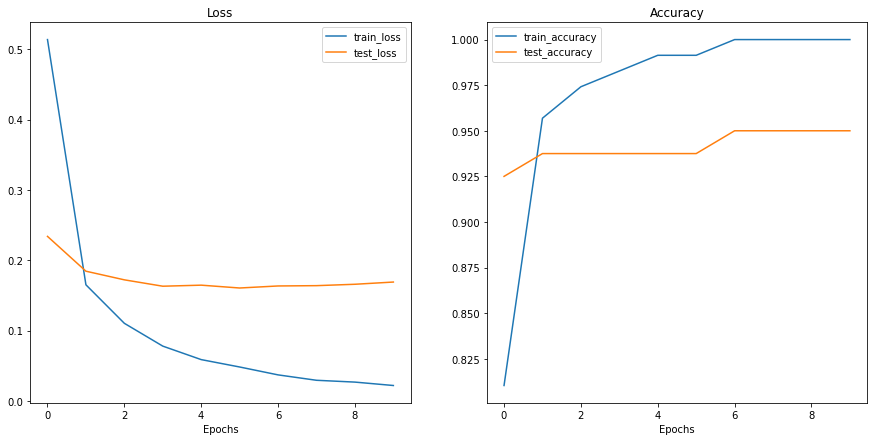

In [58]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 10.6 Save our best performing ViT model

Now we have got a model that performs quite well, now we need to save it to check its file size.

We want to check the file size because if we want to deploy a model in a website/mobile app, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions.

In [59]:
from going_moduler import utils

utils.save_model(model = pretrained_vit,q`==
                 target_dir = "models",
                 model_name = "16_pretrained_vit.pth")

[INFO] Saving model to: models/16_pretrained_vit.pth


In [62]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/16_pretrained_vit.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 11. Predicting on a Custom Image

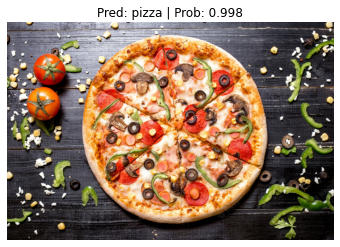

In [64]:
# Making a Prediction on Custom Image with our Best Model...
from going_moduler.predictions import pred_and_plot_image

custom_image_path = os.path.join(os.getcwd(), "Datasets", "pizza.jpg")

pred_and_plot_image(model = pretrained_vit,
                    image_path = custom_image_path,
                    class_names = class_names,
                    image_size = (224, 224))